In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import gc

os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/2023_06_12_tea_seq_atac_processing/")

path_cite_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/processed_files/"

In [2]:
## Helper functions
def pearson_corr_df_to_df(df1, df2):
    norm1 = df1 - df1.mean(axis=0)
    norm2 = df2 - df2.mean(axis=0)
    sqsum1 = (norm1**2).sum(axis=0)
    sqsum2 = (norm2**2).sum(axis=0)
    return((norm1.T @ norm2) / np.sqrt(sqsum1.apply(lambda x: x*sqsum2)))

In [3]:
new_cluster_order = pd.read_csv("/media/kyle_storage/kyle_ferchen/"\
    "grimes_lab_main/data/2021_11_mouse_optimized_cite_seq/processed_files/"\
    "r7_cluster_order_kf_2024_01.csv")
map_r7_to_lv3 = pd.Series(\
    new_cluster_order["Level 3"].values,
    index=new_cluster_order["Cluster"].values)
map_lvl3_to_order = pd.Series(\
    new_cluster_order["Order"].values,
    index=new_cluster_order["Level 3"].values)
map_r7_to_replace_dash = pd.Series(\
    new_cluster_order["Cluster"].values,
    index=[i.replace("-", "_") for i in new_cluster_order["Cluster"].values])
map_new_cluster_to_order = pd.Series(\
    new_cluster_order["Order"].values,
    index=new_cluster_order["Level 3"].values)
new_cluster_order

,Cluster,Group,Old_order,CITE-to-TEA,Order,Level 1,Level 2,Level 3,Level Kairavee
0,LT-HSC_Mllt3,HSCP,1,LT-HSC_Mllt3,1.0,HSPC,HSC,qHSC,HSC
1,ST-HSC,HSCP,2,ST-HSC,2.0,HSPC,HSC,aHSC,HSC
2,MPP4-Hlf,HSCP,3,MPP4-Hlf,3.0,HSPC,MPP4,HSC-Ly,HSPC
3,MPP5-Egr1,HSCP,8,MPP5-Egr1,4.0,HSPC,MPP5,MPP5-IER,MPP5-IER
4,MPP5-Flt3,HSCP,7,MPP5-Flt3,5.0,HSPC,MPP5,MPP5 Ly-I,HSPC
...,...,...,...,...,...,...,...,...,...
83,ILC2,ILC,84,ILC2,84.0,ILC,ILC,ILC2,ILC
84,Bcl11b+_preETP_Cd3d,ILC,85,Bcl11b+_preETP_Cd3d,85.0,T cell,preETP,pre-ILC1-ILC3-NKP,preETP
85,Bcl11b+_preETP_Tdrd5,ILC,88,Bcl11b+_preETP_Tdrd5,86.0,T cell,preETP,pre-NKP,preETP
86,ILC1-ILC3-NKP,ILC,87,ILC1-ILC3-NKP,87.0,ILC,ILC,ILC1-ILC3-NKP,ILC


In [4]:
# Seqlet annotation
seqlets = pd.read_feather("output/chrombpnet/modisco_merged_results/fold_0/"\
    "redo_extract_seqlets/all_seqlit_hits_above_modisco_min_anno.fea")

# Seqlets
dp_scores = pd.read_feather("output/chrombpnet/modisco_merged_results/fold_0/"\
    "redo_extract_seqlets/all_seqlit_hits_above_modisco_min_dp_scores.fea")
dp_scores = dp_scores.set_index("index").astype(np.float32)
dp_scores = dp_scores.rename(map_r7_to_replace_dash.to_dict(), axis=1)
dp_scores = dp_scores.rename(map_r7_to_lv3.to_dict(), axis=1)

In [5]:
# Load CITE-seq data (SoupX 0.15 corrected)
path_to_cite_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/processed_files/"

cite_adata = anndata.read_h5ad(os.path.join(\
    path_to_cite_data,
    "cite_seq_adata_rna_combined_SoupX_0_15_with_R7_clusters.h5ad"))

cite_adata.X = np.log2((10000 * (cite_adata.X.T / \
    cite_adata.X.sum(axis=1).T).T) + 1)

cite_adata.obs["lvl3"] = cite_adata.obs["R7"].replace(\
    map_r7_to_lv3.to_dict()).values
cite_adata.obs["cluster_order"] = cite_adata.obs["lvl3"].replace(\
    map_lvl3_to_order.to_dict()).values

cite_adata = cite_adata[\
    cite_adata.obs.loc[cite_adata.obs["lvl3"] != "MEP-UNK"].sort_values(\
        by="cluster_order").index.values,
    :]

cite_df = pd.DataFrame(\
    cite_adata.X,
    index=cite_adata.obs.index.values,
    columns=cite_adata.var.index.values)

cite_rna = cite_df.copy()
cite_rna["cluster"] = cite_adata.obs.loc[\
    cite_rna.index.values, "lvl3"].values
cite_rna = pd.pivot_table(cite_rna, index="cluster", aggfunc=np.mean)

In [6]:
### Read in the results from previous analysis of seqlet to gene expression cor
## Gene clusters: hierarchical clusturing across seqlet to gene r values
selected_markers_tea = pd.read_csv(\
    "output/chrombpnet/modisco_merged_results/fold_0/redo_extract_seqlets/WITH_ALL_GENES/"\
    "seqlet_to_gene_expression_correlation_tea_seq_marker_gene_annotation.csv")

## Seqlet clusters: MarkerFinder to hierarchical gene clusters
# Read in the seqlet clusters
seqlets_to_tea_marker_genes = pd.read_csv(\
    "output/chrombpnet/modisco_merged_results/fold_0/redo_extract_seqlets/WITH_ALL_GENES/"\
    "seqlet_to_gene_expression_correlation_seqlets_overlapping_tea_seq_marker_genes_annotation.csv")



In [7]:
from matplotlib.colors import ListedColormap

def build_listed_cmap(rgb_start, rgb_center, rgb_end):
    # Define a colormap to use for marker expression heatmap
    N = 256
    vals = np.ones((N*2, 4))
    vals[:N, 0] = np.linspace(rgb_start[0]/256, rgb_center[0]/256, N)
    vals[:N, 1] = np.linspace(rgb_start[1]/256, rgb_center[1]/256, N)
    vals[:N, 2] = np.linspace(rgb_start[2]/256, rgb_center[2]/256, N)
    vals[N:, 0] = np.linspace(rgb_center[0]/256, rgb_end[0]/256, N)
    vals[N:, 1] = np.linspace(rgb_center[1]/256, rgb_end[1]/256, N)
    vals[N:, 2] = np.linspace(rgb_center[2]/256, rgb_end[2]/256, N)
    return(ListedColormap(vals))

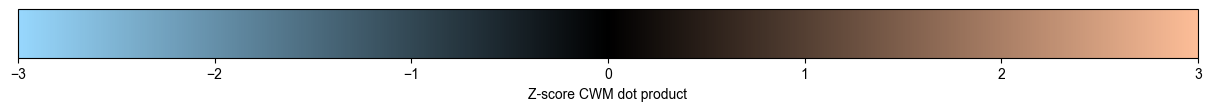

In [8]:
pantone_2023_cmap = build_listed_cmap(\
    rgb_start = (152,216,254),
    rgb_center = (0,0,0),
    rgb_end = (254,190,152))

fig, ax = plt.subplots(figsize=(12, 1), layout='constrained')

cmap = matplotlib.cm.cool
norm = matplotlib.colors.Normalize(vmin=-3, vmax=3)

fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=pantone_2023_cmap),
             cax=ax, orientation='horizontal', label='Z-score CWM dot product')

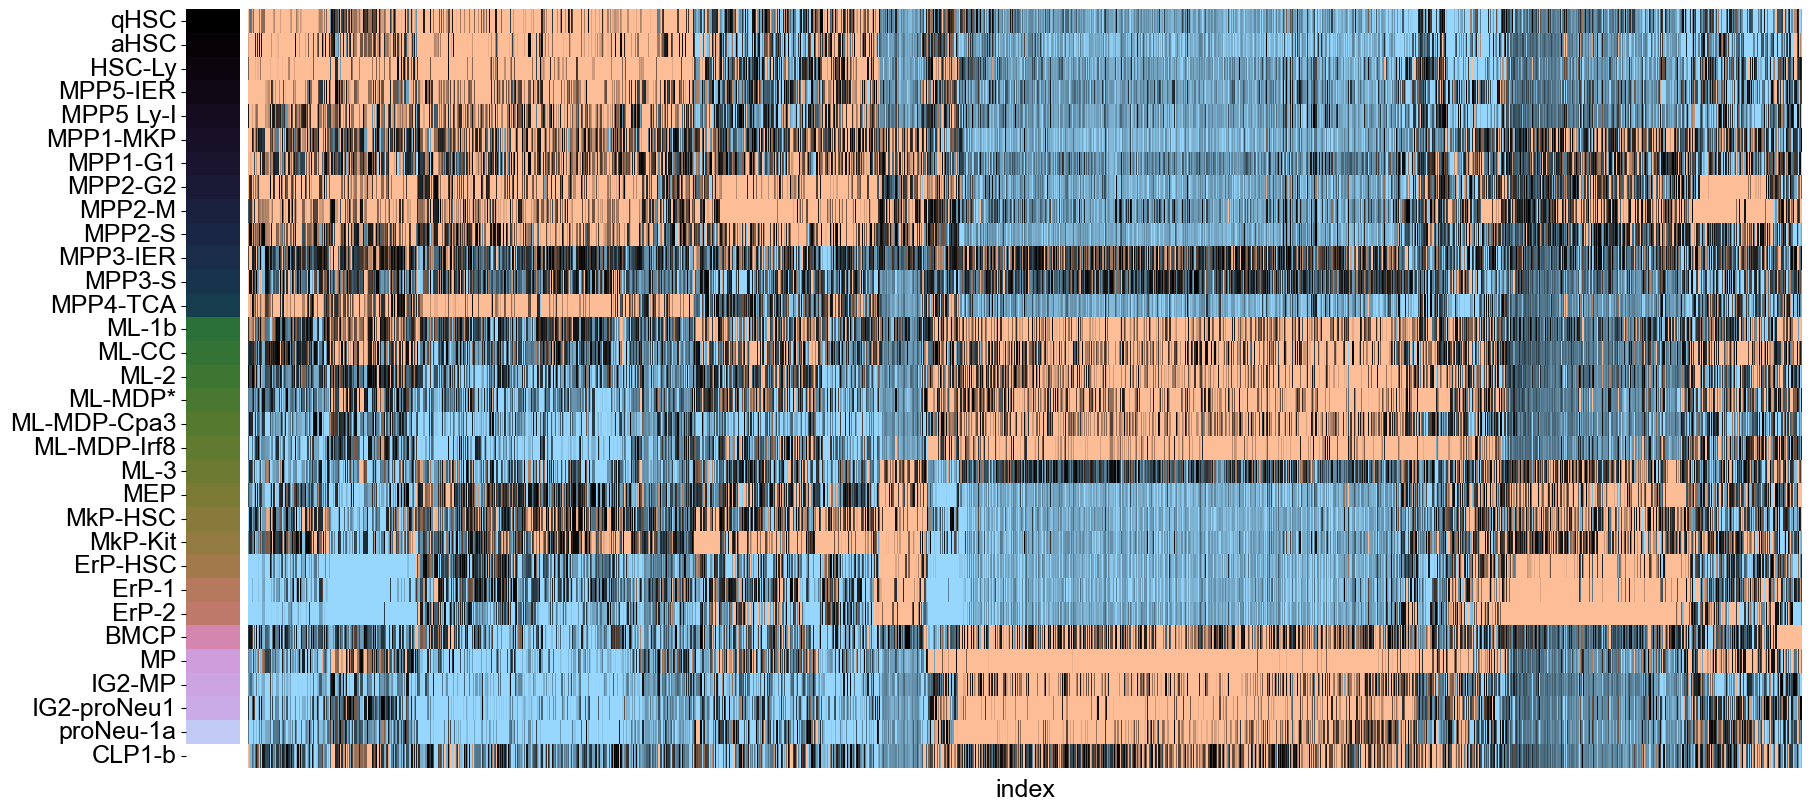

In [9]:
# Make cluster vs seqlet heatmap
ordered_cluster_series = map_new_cluster_to_order.loc[\
    dp_scores.columns.values].sort_values()

plt.rcParams.update({'font.size': 18})

# Cluster color bar
plot_cluster_bars = pd.DataFrame(ordered_cluster_series.loc[\
    dp_scores.columns.values].sort_values())

fig = plt.figure(constrained_layout=True, figsize=(18,8))
ax = fig.add_gridspec(1, 150)
ax1 = fig.add_subplot(ax[0, :5])
ax2 = fig.add_subplot(ax[0, 5:])
heat1 = sns.heatmap(plot_cluster_bars.astype(np.float32),
                        cmap="cubehelix",
                        yticklabels=True,
                        xticklabels=False,
                        cbar=False,
                        ax=ax1)

heat2 = sns.heatmap(\
    zscore(dp_scores.loc[\
        seqlets_to_tea_marker_genes["seqlet_idx"].values, 
        ordered_cluster_series.loc[\
            dp_scores.columns.values].sort_values().index.values],
        axis=1).T, 
    vmin=-1, 
    vmax=1, 
    cmap=pantone_2023_cmap,
    xticklabels=False,
    yticklabels=False,
    cbar=False,
    rasterized=True,
    ax=ax2)

plt.savefig("output/main_figure_outputs/all_genes_update/"\
    "seqlet_heatmap_ordered_by_gene_exp_to_seqlet_correlation_values_tea_seq_markers.pdf",
    dpi=300)

In [10]:
path_fig1_heatmap_stuff = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/"\
    "analysis/2023_06_14_nominate_regions_for_mpra_assay/output/plots_for_pub/"

rna_data_to_plot = pd.read_csv(os.path.join(\
        path_fig1_heatmap_stuff, 
        "rna_markers_heatmap.csv"), 
    index_col=0)
cell_assignments = pd.read_csv(os.path.join(\
        path_fig1_heatmap_stuff, 
        "cell_assigments_annotation.csv"), 
    index_col=0)
cell_assignments_reorder = cell_assignments.loc[rna_data_to_plot.columns.values]

cell_assignments_reorder["cluster"] = cell_assignments_reorder[\
    "original"].replace(map_r7_to_lv3.to_dict()).values
cell_assignments_reorder["cluster_order"] = cell_assignments_reorder[\
    "cluster"].replace(map_lvl3_to_order.to_dict()).values
cell_assignments_reorder = cell_assignments_reorder.sort_values(\
    by=["cluster_order", "top_corr"], ascending=[True, False])

cell_assignments_reorder

,top_cluster,top_corr,original,port,port_group,cluster,cluster_order
cell,,,,,,,
TCGGATAGTGTCACAT-1.AS_CITE_HSC,LT-HSC_Mllt3,0.929229,LT-HSC_Mllt3,AS_CITE_HSC,HSCP,qHSC,1.0
TTCGATTTCCTTATGT-1.AS_CITE_HSC,LT-HSC_Mllt3,0.929224,LT-HSC_Mllt3,AS_CITE_HSC,HSCP,qHSC,1.0
TTTGTTGCAGCAGTGA-1.AS_CITE_HSC,LT-HSC_Mllt3,0.928954,LT-HSC_Mllt3,AS_CITE_HSC,HSCP,qHSC,1.0
TGAGTCAGTGCTATTG-1.AS_CITE_HSC,LT-HSC_Mllt3,0.926503,LT-HSC_Mllt3,AS_CITE_HSC,HSCP,qHSC,1.0
CCTCTAGTCATAAGGA-1.AS_CITE_HSC,LT-HSC_Mllt3,0.925063,LT-HSC_Mllt3,AS_CITE_HSC,HSCP,qHSC,1.0
...,...,...,...,...,...,...,...
AGTAACCTCACCTCAC-1.AS_CITE_Multilin2,MEP-UNK,0.553438,MEP-UNK,AS_CITE_Multilin2,MultiLin,MEP-UNK,NaN
CACTGAAAGCCTGAGA-1.AS_3CITE_Kitx2,MEP-UNK,0.552790,MEP-UNK,AS_3CITE_Kitx2,CD117,MEP-UNK,NaN
CTCAATTAGGACTAAT-1.AS_CITE_HSC,MEP-UNK,0.552115,MEP-UNK,AS_CITE_HSC,HSCP,MEP-UNK,NaN


/tmp/ipykernel_18246/16792335.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_tick_positions["pos"] = list(range(1, 1+cell_tick_positions.shape[0]))


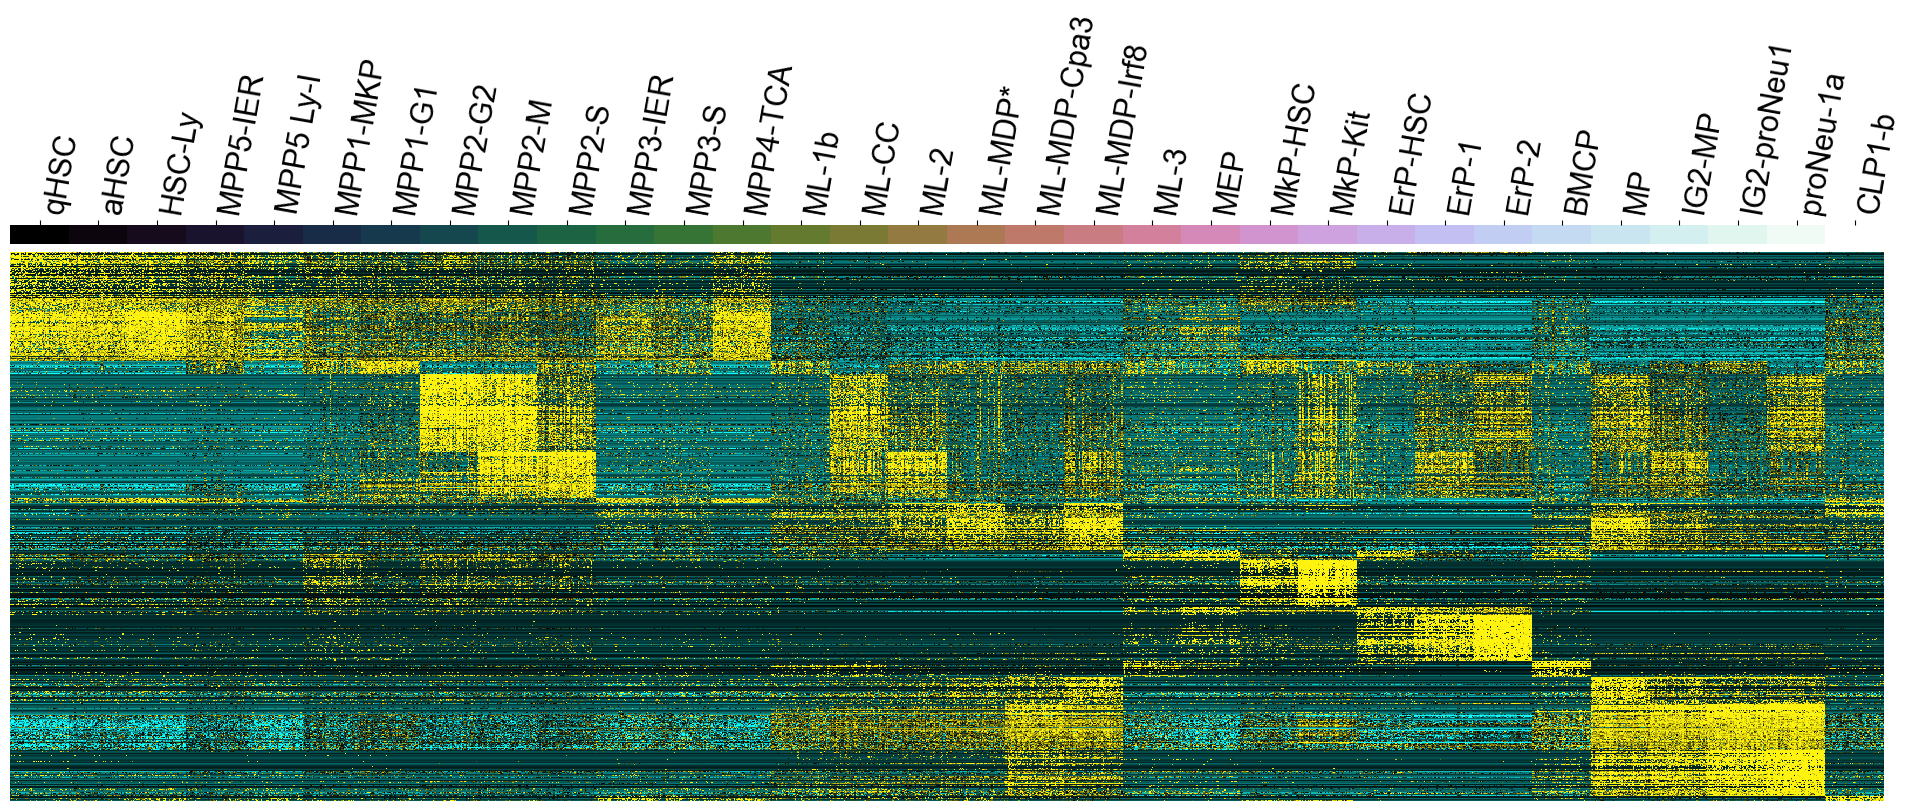

In [11]:
# Plot RNA expression heatmap
from pyInfinityFlow.Plotting_Utilities import blue_black_yellow_cmap

plt.rcParams.update({'font.size': 22})

# Prepare the ordered cells to use (borrow from figure 1 heatmap)
filtered_cells = cell_assignments_reorder.loc[\
    cell_assignments_reorder["cluster"].isin(dp_scores.columns.values)]

# Prepare cluster label positions
cell_tick_positions = filtered_cells[["cluster"]]
cell_tick_positions["pos"] = list(range(1, 1+cell_tick_positions.shape[0]))
cell_tick_positions = pd.pivot_table(\
    cell_tick_positions,
    index = "cluster",
    values = "pos",
    aggfunc = np.mean).sort_values(by="pos")

# RNA data to plot
rna_data_to_plot = zscore(cite_df.loc[\
    filtered_cells.index.values, 
    selected_markers_tea["gene"].values].T, axis=1)

# Cluster color bar
plot_cluster_bars = filtered_cells[["top_cluster"]].T.copy()
unique_clusters = plot_cluster_bars.loc["top_cluster"].unique()
map_cluster_to_order = pd.Series(\
    list(range(len(unique_clusters))), 
    index=unique_clusters).to_dict()
plot_cluster_bars.loc["top_cluster",:] = plot_cluster_bars.loc["top_cluster"].replace(\
    map_cluster_to_order)
plot_cluster_bars.columns.name = None



# Construct figure
fig = plt.figure(constrained_layout=True, figsize=(19,8))
ax = fig.add_gridspec(150, 1)
ax1 = fig.add_subplot(ax[:5, 0])
ax2 = fig.add_subplot(ax[5:, 0])
heat1 = sns.heatmap(plot_cluster_bars.astype(np.float32),
                        cmap="cubehelix",
                        yticklabels=False,
                        xticklabels=False,
                        cbar=False,
                        ax=ax1)

ax1.set_xticks(\
    ticks = cell_tick_positions["pos"].values,
    labels = cell_tick_positions.index.values, 
    ha="left")
ax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False,
    labelrotation=80)

heat2 = sns.heatmap(rna_data_to_plot, 
                        vmin=-1.5, 
                        vmax=1.5, 
                        cmap=blue_black_yellow_cmap,
                        xticklabels=False,
                        yticklabels=False,
                        cbar=False,
                        rasterized=True,
                        ax=ax2)

ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=12)


plt.savefig("output/main_figure_outputs/all_genes_update/"\
    "gene_expression_heatmap_ordered_by_gene_exp_to_seqlet_correlation_values_tea_seq_markers.pdf",
    dpi=300)

In [12]:
rna_data_to_plot.isna().sum(axis=1)

Mllt3       0
Meg3        0
Sult1a1     0
Pdzk1ip1    0
Tgm2        0
           ..
Dntt        0
Cox6a2      0
Satb1       0
Wfdc17      0
Il12a       0
Length: 597, dtype: int64

In [13]:
rna_data_to_plot.shape

(597, 1600)

In [15]:
seqlets_to_tea_marker_genes.shape

(14507, 4)